# Análisis exploratorio del conjunto de datos
A lo largo de este notebook se cubre una parte de la segunda fase de la metodología CRIPS-DM, en este caso la relativa a la exploración del conjunto de datos. 


1. **Comprensión del Negocio (Business Understanding)**
   - Consistente en el entendimiento del objetivo del proyecto.

2. <span style="color:#66FF99;">**Comprensión de los Datos (Data Understanding)**</span>  
   - Relacionada con la carga y primera evaluación del conjunto de datos. Se divide a su vez en :
        1. Carga del conjunto de datos
        2. <span style="color:#66FF99;">**Análisis exploratorio**</span>  

3. **Preparación de los Datos (Data Preparation)**  
   - Consistente en la limpieza, preparación y extracción de características de los datos.

4. **Modelado (Modeling)**  
   - Relacionada con la elección del modelo de machine learning y el ajuste hiperparamétrico.

5. **Evaluación (Evaluation)**  
   - Evaluación de los resultados obtenidos por el modelo.

6. **Implementación (Deployment)**  
   - Integración del modelo de forma que sea accesible para su uso.

Para ello, en primer lugar a las constantes del fichero `YAML` y cargamos la [API](https://github.com/cocodataset/cocoapi) de coco en memoria, para poder acceder a las segmentaciones de forma rápida

In [38]:
import importlib

from pathlib import Path
from utils import  load_yaml_file, download_zip
import os

import matplotlib.pyplot as plt

import cv2
from pycocotools.coco import COCO
import numpy as np
import random
import graphviz

import json

import pandas as pd


In [39]:
import holoviews as hv
from holoviews import dim

In [2]:
yaml = load_yaml_file()

# Constantes relativas a la direccion destino de la carga de imagenes del dataset

DIR_IMGS_DATASET_RAW = yaml["dir_datasets"]

In [3]:
dir_data_load = os.path.join(os.getcwd(),"..",DIR_IMGS_DATASET_RAW)
dir_data_load = os.path.normpath(dir_data_load)
dir_data_load

'c:\\Users\\ruben\\Desktop\\code_tfm\\dataset\\coco'

In [4]:

DIR_TRAIN_ANNOTATIONS = yaml["dirs"]["anotaciones"]["train"]
DIR_TRAIN_IMGS = yaml["dirs"]["imagenes"]["train"]
DIR_TRAIN_IMGS = os.path.join(os.getcwd(),"..", DIR_TRAIN_IMGS)

coco=COCO(os.path.join(os.getcwd(),"..", DIR_TRAIN_ANNOTATIONS))

loading annotations into memory...
Done (t=37.02s)
creating index...
index created!


Previsualizamos la info que almacena el fichero que contiene las anotaciones

In [5]:

with open( os.path.join(os.getcwd(),"..", DIR_TRAIN_ANNOTATIONS), 'r') as file:
    data = json.load(file)

print(json.dumps(data,indent=4)[:1000])  


{
    "info": {
        "description": "COCO 2017 Dataset",
        "url": "http://cocodataset.org",
        "version": "1.0",
        "year": 2017,
        "contributor": "COCO Consortium",
        "date_created": "2017/09/01"
    },
    "licenses": [
        {
            "url": "http://creativecommons.org/licenses/by-nc-sa/2.0/",
            "id": 1,
            "name": "Attribution-NonCommercial-ShareAlike License"
        },
        {
            "url": "http://creativecommons.org/licenses/by-nc/2.0/",
            "id": 2,
            "name": "Attribution-NonCommercial License"
        },
        {
            "url": "http://creativecommons.org/licenses/by-nc-nd/2.0/",
            "id": 3,
            "name": "Attribution-NonCommercial-NoDerivs License"
        },
        {
            "url": "http://creativecommons.org/licenses/by/2.0/",
            "id": 4,
            "name": "Attribution License"
        },
        {
            "url": "http://creativecommons.org/licenses/by-s

### 1. Análsis monoclase
En este caso visualizamos la clase a perdecir, correspondiente con un conjunto de etiquetas y su posición en la imagen, tratandola como un único atributo. 

Para el conjunto de datos se ha decidido que es relevante estudiar:
1. Proporción de aparición de imágenes en clase
2. Cantidad media de píxeles que ocupa cada clase en cada aparición en las imágenes que aparece
3. Frecuencia de aparición de instancias entre el número de imágenes en las que aparece

In [6]:

categories = coco.loadCats(coco.getCatIds())
category_info = {cat['id']: cat['name'] for cat in categories}

In [7]:
calses = {}

for cat_id, cat_name in category_info.items():
    img_ids = coco.getImgIds(catIds=[cat_id])
 
    calses[cat_name] = len(img_ids)

#### 1.1 Proporción de aparición de imágenes por clase

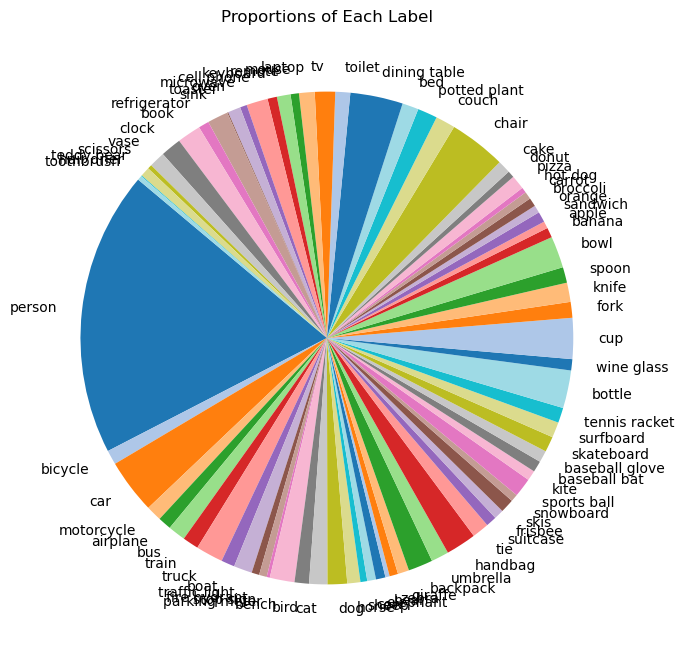

In [8]:

etiqueta = list(calses.keys())
cantidad = list(calses.values())


plt.figure(figsize=(8, 8))
plt.pie(
    cantidad,
    labels=etiqueta,
    startangle=140,
    colors=plt.cm.tab20.colors
)
plt.title("Proportions of Each Label")
plt.show()

Dado que la cantidad de categorías es muy grande impidiendo la visualización correcta de los resultados, se repite creando una categoría denominada _otros_, donde se almacenan las de menor frecuencia de aparición.

Con esto se obtiene:

In [9]:
N = 14

ordenacion = list(np.argsort(cantidad)[::-1])

clases = list(calses.keys())
cantidad = list(calses.values())

etiquetas = [clases[elem] for elem in ordenacion[:N]]
cantidades = [cantidad[elem] for elem in ordenacion[:N]]

otros = sum([cantidad[elem] for elem in ordenacion[:N]])

etiquetas.append("Otros")
cantidades.append(otros)

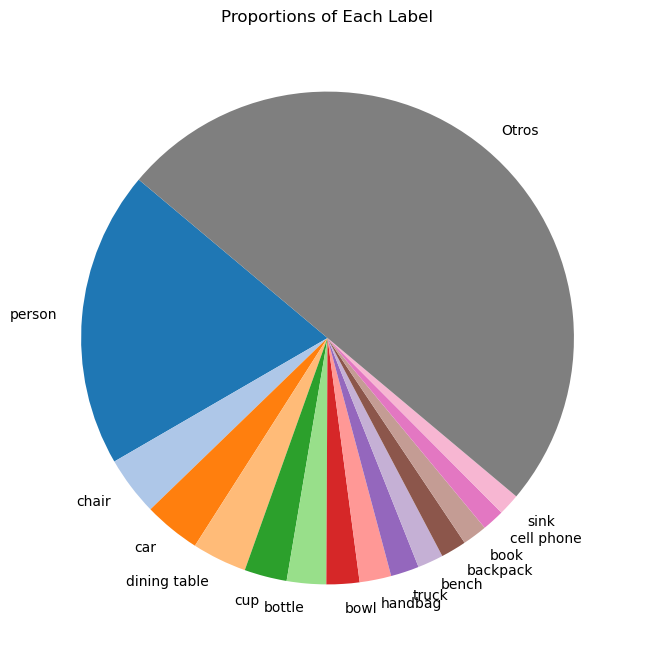

In [10]:

plt.figure(figsize=(8, 8))
plt.pie(
    cantidades,
    labels=etiquetas,
    #autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.tab20.colors
)
plt.title("Proportions of Each Label")
plt.show()



Si cambiamos el gáfico por un diagrama de barras para poder apreciar las proporciones y obtener así un mejor método para la visualización mejor se obtiene:

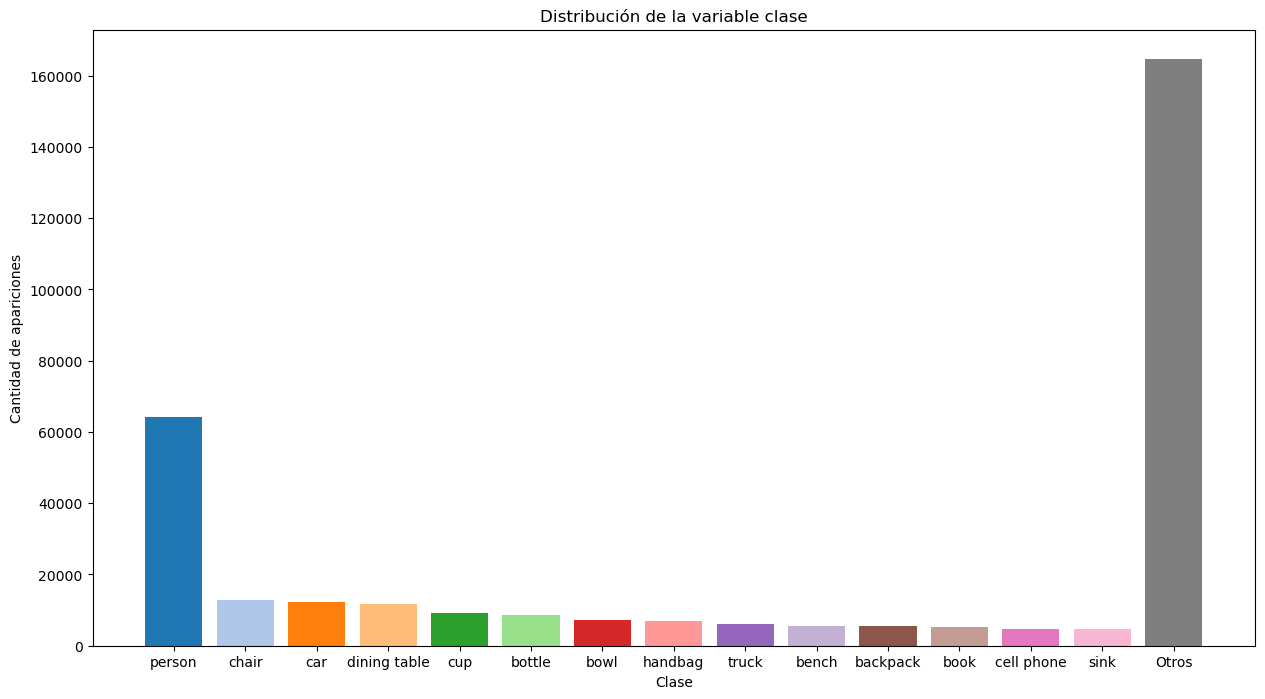

In [11]:


plt.figure(figsize=(15, 8))
plt.bar(
    etiquetas,
    cantidades,

    color=plt.cm.tab20.colors[:len(etiquetas)]
)
plt.xlabel("Clase")
plt.ylabel("Cantidad de apariciones")
plt.title("Distribución de la variable clase")
plt.show()


#### 1.2 Volumen en píxeles por imagen

Ahora se estudia por cada clase cual es el promedio de píxeles que ocupa en las imágenes en las que aparece

In [12]:
image_ids = coco.getImgIds() #Obtiene todas las imágenes

object_pixel_data = {}
object_amount_data = {}

for img_id in image_ids:
    #print("En imagen ", img_id)
    ann_ids = coco.getAnnIds(imgIds=img_id)
    annotations = coco.loadAnns(ann_ids)
    for ann in annotations:
        #print(f"hay {len(annotations)}")

        category_id = ann['category_id']
        category_name = category_info[category_id]

        #print(f"actegoria {category_id} con info {category_info[category_id]}")

        if 'segmentation' in ann and isinstance(ann['segmentation'], list):
            volumen = np.sum(coco.annToMask(ann))
            object_pixel_data[category_name] = object_pixel_data[category_name] + volumen if category_name in object_pixel_data else volumen
            object_amount_data[category_name] = object_amount_data[category_name] + 1 if category_name in object_amount_data else 1


In [13]:
print(object_pixel_data)

print(object_amount_data)

{'motorcycle': 155369206, 'person': 2824783390, 'bicycle': 52023558, 'knife': 15724063, 'cake': 132195438, 'sink': 55472835, 'cow': 83834764, 'umbrella': 93207361, 'mouse': 7210275, 'keyboard': 45175098, 'tv': 111483959, 'cat': 202523308, 'bottle': 60222030, 'potted plant': 79808500, 'refrigerator': 121226672, 'clock': 41008327, 'spoon': 10514849, 'bowl': 243553492, 'orange': 46095744, 'oven': 115377742, 'handbag': 36026724, 'wine glass': 32635456, 'dining table': 1093842056, 'cup': 94399519, 'backpack': 33355236, 'microwave': 29688275, 'book': 58673265, 'toaster': 1973980, 'fork': 11716904, 'toilet': 99050421, 'train': 240993702, 'stop sign': 35008401, 'chair': 211395195, 'laptop': 122791712, 'bench': 113620614, 'apple': 36872581, 'vase': 56423547, 'broccoli': 67363812, 'skateboard': 19994535, 'truck': 200511896, 'boat': 85278213, 'elephant': 151491713, 'teddy bear': 102910983, 'bird': 50614442, 'toothbrush': 5668076, 'cell phone': 34404459, 'car': 200442041, 'fire hydrant': 35005141,

In [14]:
category_info

{1: 'person',
 2: 'bicycle',
 3: 'car',
 4: 'motorcycle',
 5: 'airplane',
 6: 'bus',
 7: 'train',
 8: 'truck',
 9: 'boat',
 10: 'traffic light',
 11: 'fire hydrant',
 13: 'stop sign',
 14: 'parking meter',
 15: 'bench',
 16: 'bird',
 17: 'cat',
 18: 'dog',
 19: 'horse',
 20: 'sheep',
 21: 'cow',
 22: 'elephant',
 23: 'bear',
 24: 'zebra',
 25: 'giraffe',
 27: 'backpack',
 28: 'umbrella',
 31: 'handbag',
 32: 'tie',
 33: 'suitcase',
 34: 'frisbee',
 35: 'skis',
 36: 'snowboard',
 37: 'sports ball',
 38: 'kite',
 39: 'baseball bat',
 40: 'baseball glove',
 41: 'skateboard',
 42: 'surfboard',
 43: 'tennis racket',
 44: 'bottle',
 46: 'wine glass',
 47: 'cup',
 48: 'fork',
 49: 'knife',
 50: 'spoon',
 51: 'bowl',
 52: 'banana',
 53: 'apple',
 54: 'sandwich',
 55: 'orange',
 56: 'broccoli',
 57: 'carrot',
 58: 'hot dog',
 59: 'pizza',
 60: 'donut',
 61: 'cake',
 62: 'chair',
 63: 'couch',
 64: 'potted plant',
 65: 'bed',
 67: 'dining table',
 70: 'toilet',
 72: 'tv',
 73: 'laptop',
 74: 'mo

In [15]:
mean_por_clase = {}

for key in category_info.keys():
    val = category_info[key]
    mean_por_clase[val] = object_pixel_data[val] / object_amount_data[val]


labels = list(mean_por_clase.keys())
values = list(mean_por_clase.values())

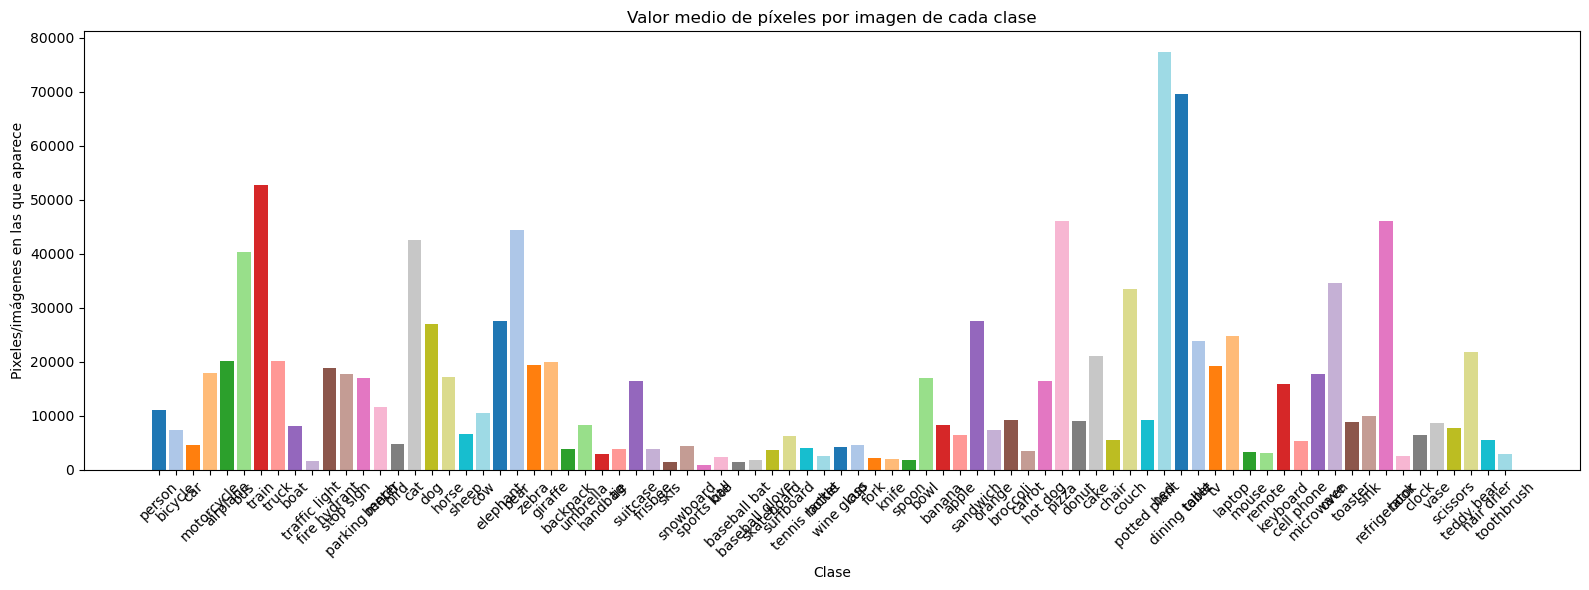

In [16]:

plt.figure(figsize=(16, 6))  
plt.bar(labels, values, color=plt.cm.tab20.colors[:len(labels)])
plt.xlabel("Clase")
plt.ylabel("Pixeles/imágenes en las que aparece")
plt.title("Valor medio de píxeles por imagen de cada clase")
plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()


De nuevo, se tiene que la alta cantidad de clases hace dificil una visualización correcta de los resultados, por lo que usamos de nuevo la clase _otros_ para mejorar el plot resultante

In [17]:
labels = list(mean_por_clase.keys())
values = list(mean_por_clase.values())

N = 14

ordenacion = list(np.argsort(values)[::-1])


etiquetas = [labels[elem] for elem in ordenacion[:N]]
cantidades = [values[elem] for elem in ordenacion[:N]]

otros = sum([values[elem] for elem in ordenacion[N:]])/len([values[elem] for elem in ordenacion[N:]])

etiquetas.append("Otros")
cantidades.append(otros)



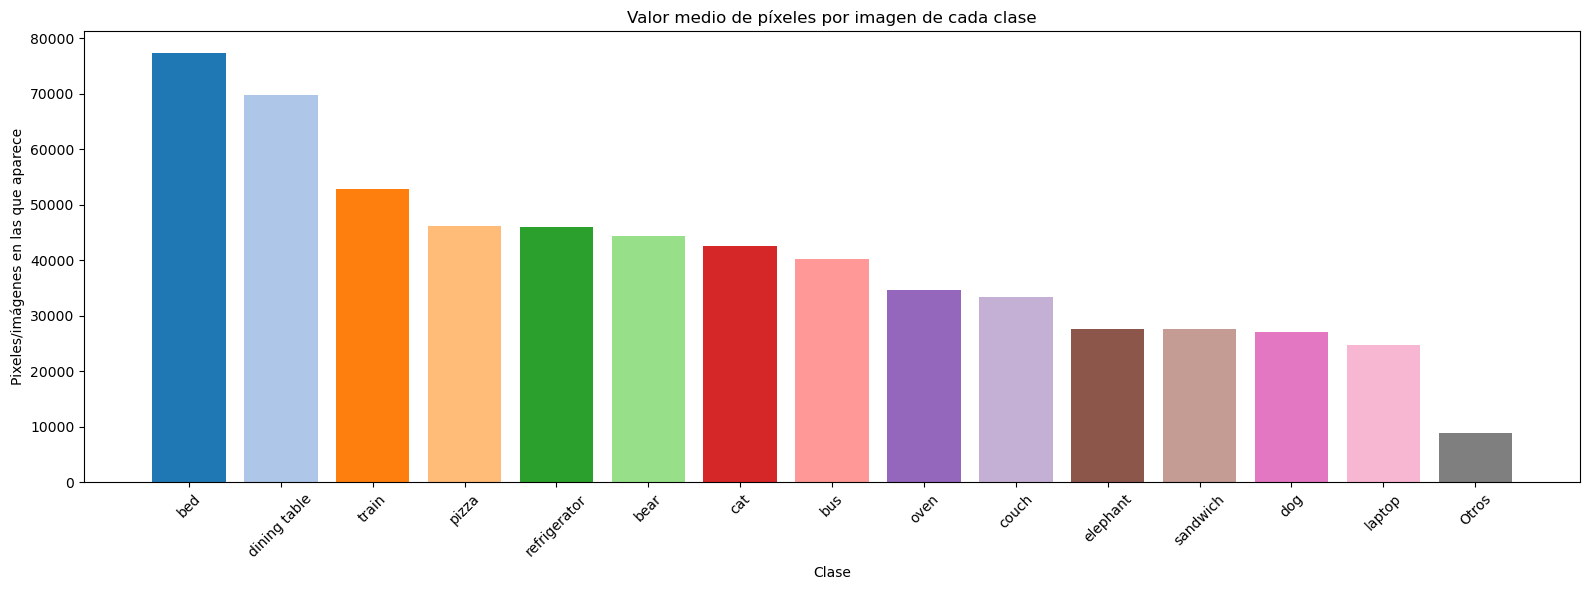

In [18]:
plt.figure(figsize=(16, 6))  
plt.bar(etiquetas, cantidades, color=plt.cm.tab20.colors[:len(labels)])
plt.xlabel("Clase")
plt.ylabel("Pixeles/imágenes en las que aparece")
plt.title("Valor medio de píxeles por imagen de cada clase")
plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()

### 1.3 Frecuencia de aparición media

Representamos la cantidad media de objetos de una clase en las imágenes que aparece al menos 1 vez:

In [19]:
mean_apariciones = {}

for i,clase in enumerate(clases):
    mean_apariciones[clase] = object_amount_data[clase] / cantidad[i]


labels = list(mean_apariciones.keys())
values = list(mean_apariciones.values())

Ahora estudiamos la proporcion de aparicion en pares de las imagenes

In [20]:

N = 14

ordenacion = list(np.argsort(values)[::-1])


etiquetas = [labels[elem] for elem in ordenacion[:N]]
cantidades = [values[elem] for elem in ordenacion[:N]]

otros = sum([values[elem] for elem in ordenacion[N:]])/len([values[elem] for elem in ordenacion[N:]])

etiquetas.append("Otros")
cantidades.append(otros)

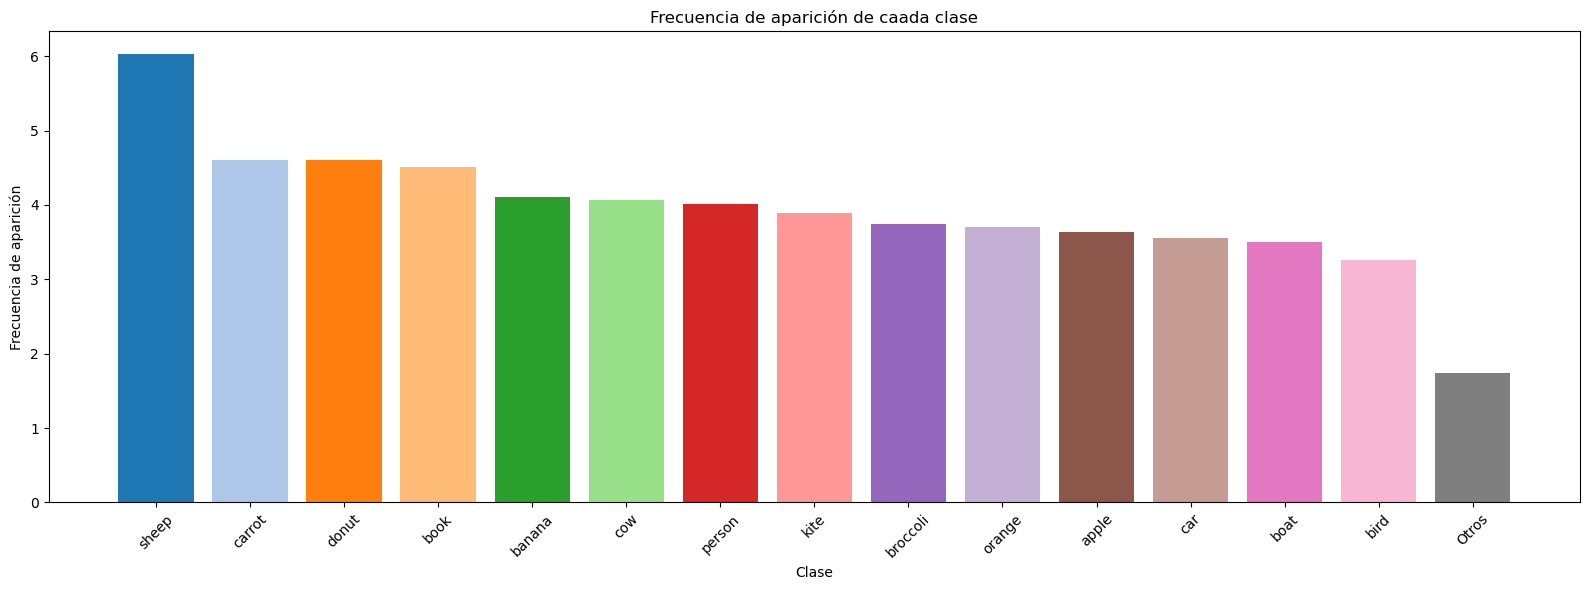

In [21]:
plt.figure(figsize=(16, 6))  
plt.bar(etiquetas, cantidades, color=plt.cm.tab20.colors[:len(labels)])
plt.xlabel("Clase")
plt.ylabel("Frecuencia de aparición")
plt.title("Frecuencia de aparición de caada clase")
plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()

### 2. Visualización multi-clase




En cuanto al análisis multiclase, se estudiará como se comportan las relaciones entre cada una de las clases a predecir.

Los casos de estudio en este caso serán los siguientes:

1. Valoraciones de las frecuencias de co-aparición en imágenes
2. Relación anterior normalizada por frecuencia de aparición por cada par a nivel individual


#### 2.1 Estudio de las frecuencias de co-aparición

Se determina que se hará uso de grafos para visualizar las dependencias entre las clases, al permitir visualizar de manera clara las relaciones entre clases.

In [22]:
[(i, category_info[i]) for i in category_info.keys()]

[(1, 'person'),
 (2, 'bicycle'),
 (3, 'car'),
 (4, 'motorcycle'),
 (5, 'airplane'),
 (6, 'bus'),
 (7, 'train'),
 (8, 'truck'),
 (9, 'boat'),
 (10, 'traffic light'),
 (11, 'fire hydrant'),
 (13, 'stop sign'),
 (14, 'parking meter'),
 (15, 'bench'),
 (16, 'bird'),
 (17, 'cat'),
 (18, 'dog'),
 (19, 'horse'),
 (20, 'sheep'),
 (21, 'cow'),
 (22, 'elephant'),
 (23, 'bear'),
 (24, 'zebra'),
 (25, 'giraffe'),
 (27, 'backpack'),
 (28, 'umbrella'),
 (31, 'handbag'),
 (32, 'tie'),
 (33, 'suitcase'),
 (34, 'frisbee'),
 (35, 'skis'),
 (36, 'snowboard'),
 (37, 'sports ball'),
 (38, 'kite'),
 (39, 'baseball bat'),
 (40, 'baseball glove'),
 (41, 'skateboard'),
 (42, 'surfboard'),
 (43, 'tennis racket'),
 (44, 'bottle'),
 (46, 'wine glass'),
 (47, 'cup'),
 (48, 'fork'),
 (49, 'knife'),
 (50, 'spoon'),
 (51, 'bowl'),
 (52, 'banana'),
 (53, 'apple'),
 (54, 'sandwich'),
 (55, 'orange'),
 (56, 'broccoli'),
 (57, 'carrot'),
 (58, 'hot dog'),
 (59, 'pizza'),
 (60, 'donut'),
 (61, 'cake'),
 (62, 'chair'),
 (6

Debido a la gran cantidad de clases del conjunto de datos, seleccionamos las que serán relevantes para nuestro problema a tratar, que en este caso serán las siguientes:

1. Person
2. Car
3. Bus
4. Traffic light
5. Backpack
6. Dining table
7. Laptop
8. Remote
9. Cell phone





In [23]:
clases_elegidas = {}

N = 10 

for key in [1,3,6, 10, 27, 67, 73,75,77]:
    clases_elegidas[key] = category_info[key]

Se genera la matriz de co-ocurrencuas 

In [24]:
origin = []
end = []
keys_seen = []
results = []

for key in clases_elegidas.keys():
    
    for key2 in clases_elegidas.keys():
        if key2 not in keys_seen:
            amount = len(coco.getImgIds(catIds=[key, key2]))
            origin.append(key)
            end.append(key2)
            results.append(amount)

    keys_seen.append(key)



In [50]:
class_ids = list(clases_elegidas.keys()) 
num_classes = len(class_ids)

co_occurrence_matrix = np.zeros((num_classes, num_classes), dtype=int)

class_id_to_index = {class_id: idx for idx, class_id in enumerate(class_ids)}

for i, key in enumerate(class_ids):
    for j, key2 in enumerate(class_ids[i:], start=i):  
        amount = len(coco.getImgIds(catIds=[key, key2]))  
        co_occurrence_matrix[i, j] = amount
        co_occurrence_matrix[j, i] = amount  

co_occurrence_df = pd.DataFrame(co_occurrence_matrix, index=class_ids, columns=class_ids)

print(co_occurrence_df)

       1      3     6     10    27     67    73    75    77
1   64115   8519  3011  2450  5034   5869  1754  2058  3830
3    8519  12251  2125  2534  1033    310    56    12   470
6    3011   2125  3952   857   478     32     6     0    90
10   2450   2534   857  4139   450     26     6     2   110
27   5034   1033   478   450  5528    289   223   113   480
67   5869    310    32    26   289  11837   567   433   746
73   1754     56     6     6   223    567  3524   374   721
75   2058     12     0     2   113    433   374  3076   267
77   3830    470    90   110   480    746   721   267  4803


In [58]:
def get_color(valor):

    total = sum(results) / len(results)

    if(valor > total * 1.1):
        return "red"
    
    elif (valor < total * 0.9):
        return "green"
    
    return "orange"
    

In [61]:

dot = graphviz.Graph(format='png') 

for key in clases_elegidas.keys():

    dot.node(clases_elegidas[key],clases_elegidas[key])

for n1, n2, val in zip(origin, end, results):
    dot.edge(clases_elegidas[n1], clases_elegidas[n2], label=str(round(val,2)), color = get_color(val))




In [62]:
dot.render('grafo',view=True)  

'grafo.png'

In [89]:
origin = []
end = []
keys_seen = []
results = []

for key in clases_elegidas.keys():
    
    for key2 in clases_elegidas.keys():
        if key2 not in keys_seen and key2!= key:
            
            amount = 2* len(coco.getImgIds(catIds=[key, key2])) / (len(coco.getImgIds(catIds=[ key2])) + len(coco.getImgIds(catIds=[key])))
            origin.append(key)
            end.append(key2)
            results.append(amount)

    keys_seen.append(key)

In [93]:
def get_color(valor, results):
    p5 = np.percentile(results, 5)
    p20 = np.percentile(results, 20)
    p80 = np.percentile(results, 80)
    p95 = np.percentile(results, 95)

    if valor <= p5:
        return "#10f208"  # Dark Blue (Extreme Low)
    elif valor <= p20:
        return "#00ffe5"  # Light Blue (Low)
    elif valor <= p80:
        return "#B0B0B0"  # Gray (Neutral)
    elif valor <= p95:
        return "#e5ff00"  # Light Red (High) e5ff00
    else:
        return "#ff0400"  # Dark Red (Extreme High)

In [94]:

dot = graphviz.Graph(format='png') 

for key in clases_elegidas.keys():

    dot.node(clases_elegidas[key],clases_elegidas[key])

for n1, n2, val in zip(origin, end, results):
    dot.edge(clases_elegidas[n1], clases_elegidas[n2], label=str(round(val,2)), color = get_color(val, results= results))



In [95]:
dot.render('grafo',view=True)  

'grafo.png'